In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import os
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [14]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
all_data = pd.concat((train_data.loc[:,'MSSubClass':'SaleCondition'],test_data.loc[:,'MSSubClass':'SaleCondition']))
matplotlib.rcParams['figure.figsize'] = (15.0, 6.0)
prices = pd.DataFrame({'price':train_data["SalePrice"],"log(price+1)":np.log1p(train_data["SalePrice"])})
# _ = prices.hist()

In [248]:
#x_train = train.iloc[:,:80]
#y_train = train.iloc[:,80:]
#x_train.shape
#scatter_matrix(x_train)
#x_train.hist(figsize=(18,14))
#plt.show()
#train_data.columns

In [4]:
train_trimmed.shape

(1460, 23)

In [5]:
################################################################
# Shuffle our trimmed data and set aside test set
################################################################
def shuffleSplitData(data, train_size):
    #rand = np.random.randint()
    num_cols = data.shape[1] - 1
    #print(data.shape[1])
    #print(num_cols)
    features = data.iloc[:,:num_cols]
    target = data.iloc[:,num_cols:]
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, train_size=train_size)
    print("Xtrain is: {}".format(X_train.shape))
    print(X_test.shape) 
    print(y_train.shape)
    print(y_test.shape)
    return (X_train, X_test, y_train, y_test)

def shuffle_train_data(data, test_ratio = 0):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

def splitData(data):
    cols = data.shape[1] - 1
    X = data.iloc[:,:cols]
    y = data.iloc[:,cols:]
    return X, y

def calculateRMSE(y_hat, y):
    sub = np.subtract(y_hat, y)
    square = np.power(sub, 2)
    rmse = sqrt(square.mean()/y.shape[0])
    return rmse
    
    
def getCVrmse(model, X, y):
    return (np.sqrt(-cross_val_score(clf, X, y, scoring="neg_mean_squared_error", cv = 5)))

In [6]:
##################################################################
# Fit model
##################################################################
def trainModel(data, alpha, model, test_ratio=0.2):
    data_copy = data.copy()
    #X_train, X_test, y_train, y_test = shuffleSplitData(data_copy, train_size)
    train, test = shuffle_train_data(data_copy, test_ratio=test_ratio)
    X_train, y_train = splitData(train)
    X_test, y_test = splitData(test)
    if model == 'Ridge':
        clf = Ridge(alpha=alpha, normalize=True)
    if model == 'Lasso':
        clf = Lasso(alpha=alpha, normalize=True)
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    return calculateRMSE(y_hat, y_test)
    
    #rmse = getCVrmse(clf, X_train, y_train)
    #return rmse

In [15]:
#########################################################
# Prep the data
########################################################
#log transform the target:
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)

## Remove columns with more than 100 nans
toomanynans = all_data.isnull().sum() < 100
all_data = all_data[toomanynans.index[toomanynans]]

## Remove non int non float columns
# = pd.DataFrame(train_data_copy.select_dtypes(include=['float64', 'int64']))

## Fill rest with average
all_data = all_data.fillna(all_data.mean())

In [20]:
num_alphas = 30
alphas = [0.001*1.5**x for x in range(num_alphas)]

rmses = []
#train_data_copy = train_data.copy()

for alpha in alphas:
    temp_copy = all_data.copy()
    rmses.append(trainModel(temp_copy, alpha, model='Ridge'))



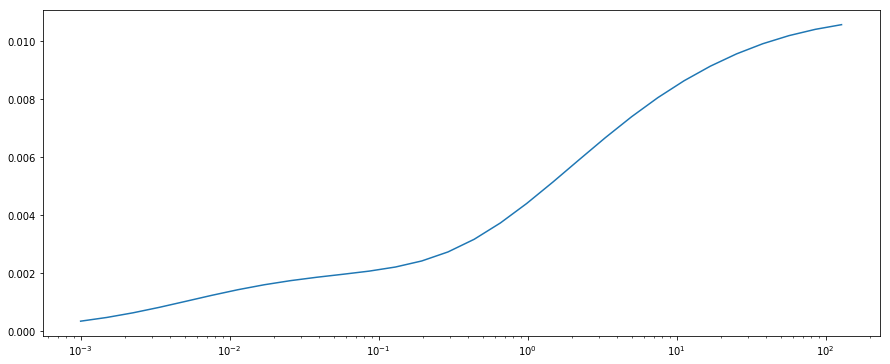

In [21]:
_ = plt.semilogx(alphas, rmses)

In [19]:
print(alphas)

[0.001, 0.0015, 0.0022500000000000003, 0.003375, 0.0050625, 0.00759375, 0.011390625, 0.0170859375, 0.02562890625, 0.038443359375, 0.0576650390625, 0.08649755859375, 0.129746337890625, 0.1946195068359375, 0.29192926025390625]


In [3]:
###########################################################
# Remove columns that have low correlation
###########################################################
corr_matrix = train_data.corr()

# Uncomment for list of column correlation
#print(corr_matrix["SalePrice"].sort_values(ascending=False))

####TODO fix for negatively correlated
train_trimmed = train_data.copy()

pos_cols = corr_matrix["SalePrice"] > 0.1
#neg_cols = corr_matrix["SalePrice"] < -0.1 

train_trimmed = train_trimmed[pos_cols.index[pos_cols]]
#train_trimmed = train_trimmed[neg_cols.index[neg_cols]]

###########################################################
#Then remove all NaN entries, replace with mean
###########################################################
# Show NaN counts
#train_trimmed.isnull().sum()

# Based what the columns are, it may be better to drop those columns
train_trimmed.drop(['LotFrontage', 'GarageYrBlt'], axis=1, inplace=True)

# And replace with avg MasVnrArea because it only had 8 nan
train_trimmed = train_trimmed.fillna(train_trimmed.mean())

# Verify
#train_trimmed.isnull().sum()


############################################################
# Graveyard
#train_trimmed.drop([columns.index[columns]], axis=1, inplace=True) #| corr_matrix["SalePrice"] < 0.1
#train_trimmed.drop([train_trimmed[co]])